In [1]:
# Justin Madsen
# DSC630 / Fadi Alsaleem

# import the boys
import numpy as np
import pandas as pd



import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import sklearn
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


import re
import string

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 1000)

In [2]:
# https://www.kaggle.com/datasets/prasertk/oil-and-gas-stock-prices
# import the dataset
spotify_df = pd.read_csv('songs_normalize.csv')

In [3]:
# did it work?
spotify_df.head(2)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.355,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.612,0.684,148.726,"rock, pop"


In [4]:
# get a baseline for the shape
spotify_df.shape

(2000, 18)

In [5]:
# let's convert the genres into a list rather than a basic string
def genre_to_list(df):
    df['genre_list'] = df['genre'].apply(lambda x: x.split(" "))
    return df

In [6]:
# conversion time
spotify_df = genre_to_list(spotify_df)

# did it work?
spotify_df.head(2)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,genre_list
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.355,0.894,95.053,pop,[pop]
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.612,0.684,148.726,"rock, pop","[rock,, pop]"


In [7]:
# let's describe the data, and pivot the table with .T
spotify_df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_ms,2000.0,228748.124500,39136.569008,113000.000000,203580.00000,223279.50000,248133.000000,484146.000
year,2000.0,2009.494000,5.859960,1998.000000,2004.00000,2010.00000,2015.000000,2020.000
popularity,2000.0,59.872500,21.335577,0.000000,56.00000,65.50000,73.000000,89.000
danceability,2000.0,0.667437,0.140416,0.129000,0.58100,0.67600,0.764000,0.975
energy,2000.0,0.720366,0.152745,0.054900,0.62200,0.73600,0.839000,0.999
key,2000.0,5.378000,3.615059,0.000000,2.00000,6.00000,8.000000,11.000
loudness,2000.0,-5.512435,1.933482,-20.514000,-6.49025,-5.28500,-4.167750,-0.276
mode,2000.0,0.553500,0.497254,0.000000,0.00000,1.00000,1.000000,1.000
speechiness,2000.0,0.103568,0.096159,0.023200,0.03960,0.05985,0.129000,0.576
acousticness,2000.0,0.128955,0.173346,0.000019,0.01400,0.05570,0.176250,0.976


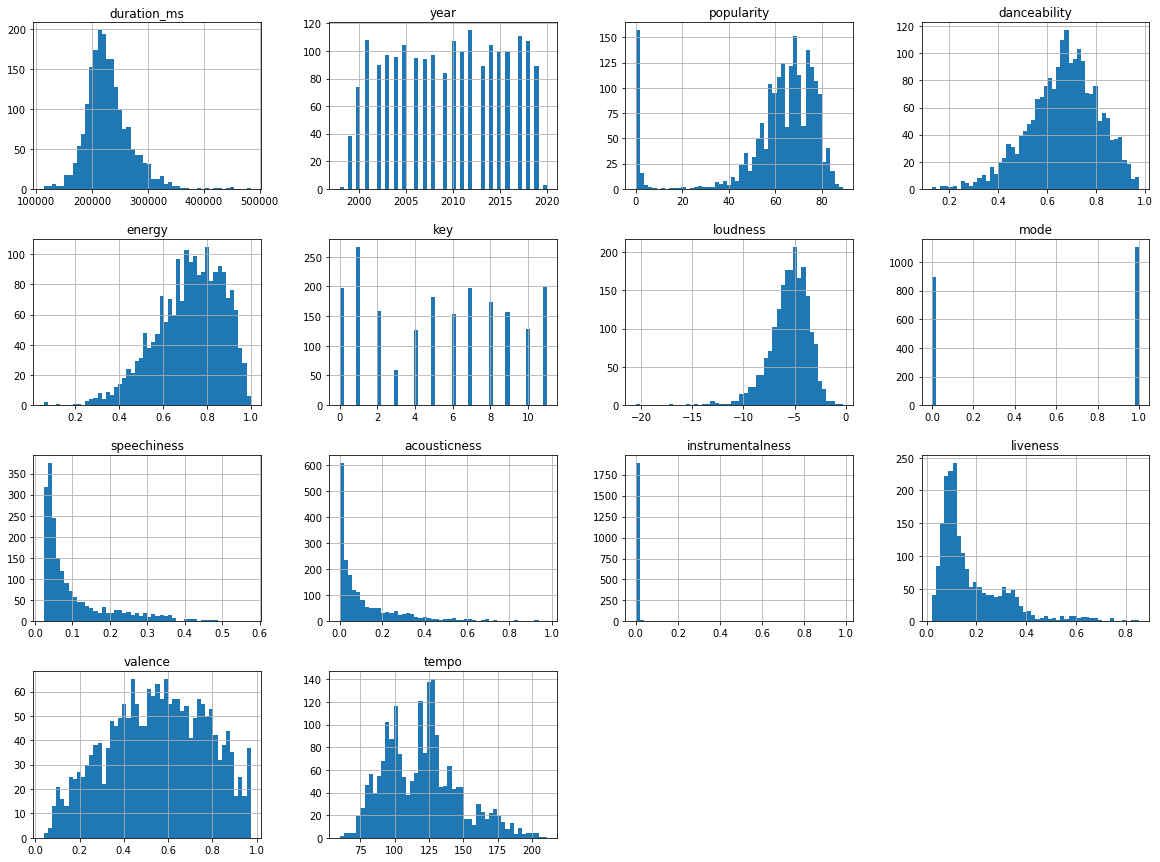

In [8]:
# let's plot histograms for each variable to see what the distributions look like
spotify_df.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
# here we'll convert the popularity into bins for popular/not popular
spotify_df["popularity_binned"] = pd.cut(spotify_df["popularity"],
                              bins = [0, 62, 90],
                              labels = [0, 1], include_lowest=True)

In [10]:
# let's show the distribution of pop vs not pop
spotify_df["popularity_binned"].value_counts(dropna=False, normalize=True)*100

1    59.3
0    40.7
Name: popularity_binned, dtype: float64

In [11]:
# I originally had an entire section for deleting duplicates, however this broke the SSS due to indexing issues. 
# these have since been removed and this started working again.

split = StratifiedShuffleSplit(n_splits=1 ,test_size=0.2, random_state=9001)

for train_index, test_index in split.split(spotify_df, spotify_df["popularity_binned"]):
    split_train = spotify_df.loc[train_index]
    split_test = spotify_df.loc[test_index]

In [12]:
# let's check the skew and kurtosis for the data
skew = pd.Series(split_train.skew(),name="skew")
kurtosis = pd.Series(split_train.kurtosis(),name="kurtosis")
pd.concat([skew,kurtosis],axis =1)

C:\Users\MYDICK~1\AppData\Local\Temp/ipykernel_44148/1428877543.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew = pd.Series(split_train.skew(),name="skew")
C:\Users\MYDICK~1\AppData\Local\Temp/ipykernel_44148/1428877543.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kurtosis = pd.Series(split_train.kurtosis(),name="kurtosis")


,skew,kurtosis
duration_ms,1.018902,3.265376
explicit,1.022867,-0.954939
year,-0.028587,-1.200091
popularity,-1.845393,2.757777
danceability,-0.459228,0.159500
energy,-0.656024,0.312530
key,-0.012106,-1.288990
loudness,-1.262497,4.363057
mode,-0.206279,-1.959900
speechiness,1.774119,2.687664


Speechiness, loudness, instrumentalness and liveness are skewed. While instrumentalness has quite a high kurtosis. StandardScaler() may be helpful to bring this all in line with each other.

In [13]:
# let's go through the columns and start processing the data
# .head to get the column names faster
split_train.head(2)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,genre_list,popularity_binned
1869,Drake,In My Feelings,217925,True,2018,75,0.835,0.626,1,-5.833,1,0.1250,0.0589,0.00006,0.396,0.350,91.030,"hip hop, pop, R&B","[hip, hop,, pop,, R&B]",1
1511,The Weeknd,The Hills,242253,True,2015,84,0.585,0.564,0,-7.063,0,0.0515,0.0671,0.00000,0.135,0.137,113.003,"pop, R&B","[pop,, R&B]",1


In [14]:
split_train['duration_ms'].describe()
# duration is important, however ms is a tad unwieldy. We should convert this column into full seconds

count      1600.000000
mean     229066.065625
std       39484.854532
min      114893.000000
25%      203502.750000
50%      223471.500000
75%      248639.500000
max      484146.000000
Name: duration_ms, dtype: float64

In [15]:
split_train['explicit'].describe()
# this is a t/f boolean. Feeding this into a model, this might be best converted to a 1/0. However, I don't think it will be
# necessary to.

count      1600
unique        2
top       False
freq       1164
Name: explicit, dtype: object

In [16]:
split_train['year'].value_counts
# year column doesn't seem to be too relevant. However, to limit the amount of options let's bin this

<bound method IndexOpsMixin.value_counts of 1869    2018
1511    2015
1743    2017
201     2002
856     2008
        ... 
1406    2014
67      2000
482     2003
1530    2014
300     2003
Name: year, Length: 1600, dtype: int64>

In [17]:
# let's take the release year and subtract it from the current year in both train and test sets
split_train['age'] = 2022 - split_train['year'] 
split_test['age'] = 2022 - split_test['year'] 

# now we'll bin them in both to reduce the variability
split_train["age_binned"]=pd.cut(split_train["age"],
                              bins = [0, 5, 15, 30],
                              labels = [1, 2, 3], include_lowest = True)

split_test["age_binned"]=pd.cut(split_test["age"],
                              bins = [0, 5, 15, 30],
                              labels = [1, 2, 3],include_lowest = True)

In [18]:
# Danceability - A value of 0.0 is least danceable and 1.0 is most danceable.
split_train['danceability'].describe()

# this variable is already fairly preprocessed. This won't need any work from me.

count    1600.000000
mean        0.671513
std         0.141112
min         0.179000
25%         0.585000
50%         0.680000
75%         0.771000
max         0.975000
Name: danceability, dtype: float64

In [19]:
# Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
split_train['energy'].describe()

# this variable is already fairly preprocessed. This won't need any work from me.

count    1600.000000
mean        0.721387
std         0.151418
min         0.054900
25%         0.626000
50%         0.736000
75%         0.841000
max         0.999000
Name: energy, dtype: float64

In [20]:
# Key - he key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. 
split_train['key'].describe()

# song keys are typically categorical. This column will need to be altered a bit to take this into account

count    1600.000000
mean        5.363750
std         3.612422
min         0.000000
25%         2.000000
50%         6.000000
75%         8.000000
max        11.000000
Name: key, dtype: float64

In [21]:
# Loudness - Values typically range between -60 and 0 db. 
split_train['loudness'].describe()

# this variable is already fairly preprocessed. This won't need any work from me.

count    1600.000000
mean       -5.503811
std         1.927214
min       -20.514000
25%        -6.479000
50%        -5.263500
75%        -4.167000
max        -0.276000
Name: loudness, dtype: float64

In [22]:
# Feature 8: mode: Mode indicates the modality (major or minor) of a track,
# the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
split_train['mode'].value_counts()

# mode here is being used similarly to a t/f boolean, however is being shown as maj/min boolean.
# This won't need any work from me.

1    882
0    718
Name: mode, dtype: int64

In [23]:
# Speechiness detects the presence of spoken words in a track. The more exclusively speech-like 
# the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values 
# above 0.66 describe tracks that are probably made entirely of spoken words. 
# Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, 
# including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
split_train['speechiness'].describe()

# this variable is already fairly preprocessed. This won't need any work from me.

count    1600.000000
mean        0.103749
std         0.096478
min         0.023200
25%         0.039850
50%         0.060000
75%         0.128000
max         0.576000
Name: speechiness, dtype: float64

In [24]:
# Acousticness: A confidence measure from 0.0 to 1.0 
# of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
split_train['acousticness'].describe()

# this variable is already fairly preprocessed. This won't need any work from me.

count    1600.000000
mean        0.126943
std         0.171726
min         0.000019
25%         0.013475
50%         0.054750
75%         0.173250
max         0.976000
Name: acousticness, dtype: float64

In [25]:
# Instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this 
# context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater 
# likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but
# confidence is higher as the value approaches 1.0
split_train['instrumentalness'].describe()

# this variable is already fairly preprocessed. However, the skewness and kurtosis of this column indicates that a standard
# scaler might help make this easier to work with. (75% percentile is only .000062, however max is .985000)

count    1600.000000
mean        0.016573
std         0.092426
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000071
max         0.985000
Name: instrumentalness, dtype: float64

In [26]:
# liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability
# that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
split_train['liveness'].describe()

count    1600.000000
mean        0.179024
std         0.140756
min         0.021500
25%         0.086775
50%         0.124000
75%         0.233250
max         0.853000
Name: liveness, dtype: float64

In [27]:
# Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high
# valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative
# (e.g. sad, depressed, angry).
split_train['valence'].describe()

# this variable is already fairly preprocessed. This won't need any work from me.

count    1600.000000
mean        0.555079
std         0.223600
min         0.038100
25%         0.387000
50%         0.560500
75%         0.738000
max         0.973000
Name: valence, dtype: float64

In [28]:
# tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, 
# tempo is the speed or pace of a given piece and derives directly from the average beat duration.
split_train['tempo'].describe()

# this variable is already fairly preprocessed. This won't need any work from me.

count    1600.000000
mean      119.565425
std        26.890377
min        60.019000
25%        98.060000
50%       119.992000
75%       133.592000
max       210.851000
Name: tempo, dtype: float64

We've cleaned up the genres, and decided a standard scaler will be useful for instrumentalism. Converting ms might be useful.
Now let's look at some correlation matrices

In [29]:
correlation_matrix_spotify = split_train.corr()

# let's grab the popularity column to see if there's any strong correlations to popularity from other variables
correlation_matrix_spotify.popularity

# doesn't appear to be any strong correlations here.

duration_ms         0.054830
explicit            0.080530
year               -0.022828
popularity          1.000000
danceability        0.006018
energy             -0.016046
key                 0.034523
loudness            0.039392
mode               -0.024705
speechiness         0.038875
acousticness        0.019229
instrumentalness   -0.063858
liveness           -0.012743
valence            -0.029968
tempo              -0.003411
age                 0.022828
Name: popularity, dtype: float64

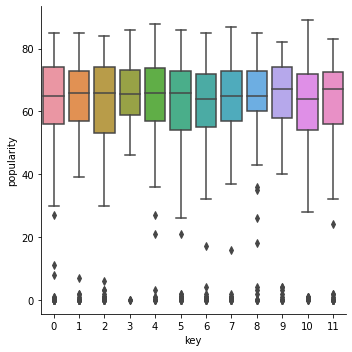

In [30]:
# let's look to see how popularity compares to the key of the song
sns.catplot(x="key", y="popularity", kind="box", data=spotify_df)

# here we can see that key 3 (D#) has a tighter popularity, where as key 4 (E) has a much wider spread with more outliers

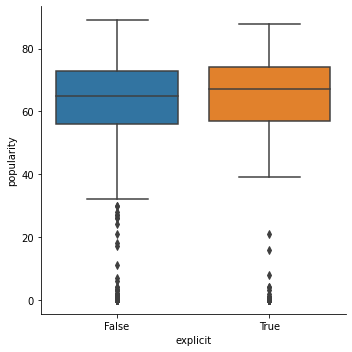

In [31]:
sns.catplot(x="explicit", y="popularity", kind="box", data=spotify_df)

# this leads to me believe that explicit songs are more popular, due to the tighter spread on true.
# However, the overall spreads are similar enough that I can't see a real correlation between the explicity and popularity.

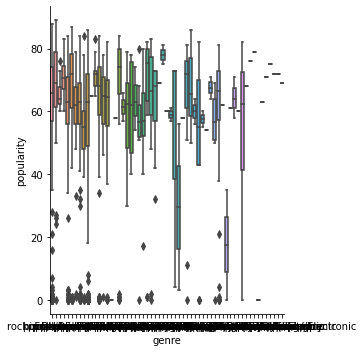

In [32]:
sns.catplot(x="genre", y="popularity", kind="box", data=spotify_df)
# well. That's an ugly chart. But we can see a very wide spread amongst all genres. Even if this is unreadable. I would
# most likely have to split things up by genre in order to find any real correlation between the genres themselves

In [33]:
# let's clean up the text columns

# grab the stopwords from nltk
STOPWORDS = set(stopwords.words('english'))

# grab the punctuation from the string library
PUNCT_TO_REMOVE = string.punctuation

# let's get rid of those punctuations
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# clean the text with pounctuation remover
def text_clean(x):
    split_train[x]= split_train[x].str.lower() # lower case all the text for easier parsing
    split_train[x] = split_train[x].apply(lambda x: remove_punctuation(x)) # delete the punctuation
    
# just remove the stop words from the nltk library
def remove_stopwords(x):
    return " ".join([word for word in str(x).split() if word not in STOPWORDS])


# run the functions based on column name
text_clean('genre')
text_clean('song')
text_clean('artist')

# run the functions for both train and test sets
split_train['genre'] = split_train['genre'].apply(lambda x: remove_stopwords(x))
split_train['song'] = split_train['song'].apply(lambda x: remove_stopwords(x))
split_train['artist'] = split_train['artist'].apply(lambda x: remove_stopwords(x))

split_test['genre'] = split_test['genre'].apply(lambda x: remove_stopwords(x))
split_test['song'] = split_test['song'].apply(lambda x: remove_stopwords(x))
split_test['artist'] = split_test['artist'].apply(lambda x: remove_stopwords(x))

In [34]:
# let's use PorterStemmer to normalize some of the slang words
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# apply to both test and train
split_train["genre"] = split_train["genre"].apply(lambda text: stem_words(text))
split_train["song"] = split_train["song"].apply(lambda text: stem_words(text))

split_test["genre"] = split_test["genre"].apply(lambda text: stem_words(text))
split_test["song"] = split_test["song"].apply(lambda text: stem_words(text))

In [35]:
# lemmatizer merges inflected words with their real words for easier processing
lemmatizer = WordNetLemmatizer()

# map the words to their identifiers for easier processing
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

# function to run the lematizer based on the map
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


# apply to both sets
split_train["genre"] = split_train["genre"].apply(lambda text: lemmatize_words(text))
split_train["song"] = split_train["song"].apply(lambda text: lemmatize_words(text))

split_test["genre"] = split_test["genre"].apply(lambda text: lemmatize_words(text))
split_test["song"] = split_test["song"].apply(lambda text: lemmatize_words(text))

In [36]:
# let's create an object to hold all the column names that are numerical
all_no_text = ['duration_ms', 'explicit', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 
               'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity_binned', 'age_binned']

all_w_text = ['artist', 'song','genre', 'duration_ms', 'explicit', 'year',  'danceability',
              'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
              'valence', 'tempo', 'popularity_binned', 'age', 'age_binned']

In [37]:
# let's make the train and test set and get everything sorted
X_train = split_train[all_no_text]
Y_train = split_train['popularity_binned']

X_test = split_test[all_no_text]
Y_test = split_test['popularity_binned']

X_train_text = split_train[all_w_text]
X_test_text = split_test[all_w_text]

In [38]:
# let's set up the encoders and scalers
ohe = OneHotEncoder(handle_unknown='ignore')
oe = OrdinalEncoder()
scaler = StandardScaler()
vect = CountVectorizer()

logreg = LogisticRegression(solver='liblinear', multi_class='auto', random_state=9001, max_iter=1000)

In [39]:
# Let's make the column transformer
ct = make_column_transformer(
    (ohe, ['explicit', 'key']),
    (oe,['age_binned']),
    (scaler, ['duration_ms', 'danceability', 'energy', 'loudness', 'mode',
              'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']), remainder='drop')

In [40]:
# Pipeline for Logistic Regression Classification problem

# here we make the pipeline, and pass in nthe transformer before applying the logreg
pipe_LR = make_pipeline(ct, logreg)

# now we fit the logreg
pipe_LR.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['age_binned']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=9001,
                                    solver='liblinear'))])

In [41]:
# let's get the cross validation score after a few repititions
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=9001)

cross_val_score(pipe_LR, X_train, Y_train, cv=cv, scoring='accuracy').mean()

0.6151875

In [42]:
# let's apply logreg params and see which regression works best
params = {}
params['logisticregression__penalty'] = ['l1', 'l2']
params['logisticregression__C'] = [0.1, 1, 10]

In [43]:
# let's apply the model and params to see average responses and how long the models take to run
grid = GridSearchCV(pipe_LR, params, cv=cv, scoring='accuracy')
grid.fit(X_train, Y_train);

In [44]:
# now let's make a df of the results and desplay them.
results = pd.DataFrame(grid.cv_results_)
# let's sort them for easier readability
results.sort_values('rank_test_score')

# based off the sort, I can already tell the best avg score is .618125, using penalty l1 and C of 1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,split91_test_score,split92_test_score,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,mean_test_score,std_test_score,rank_test_score
2,0.017367,0.003080,0.003899,0.000856,1,l1,"{'logisticregression__C': 1, 'logisticregressi...",0.64375,0.61875,0.57500,0.63125,0.64375,...,0.55625,0.61875,0.64375,0.60000,0.62500,0.63750,0.65000,0.60000,0.60625,0.617688,0.028077,1
1,0.009243,0.002263,0.004081,0.001079,0.1,l2,"{'logisticregression__C': 0.1, 'logisticregres...",0.64375,0.61875,0.57500,0.63125,0.62500,...,0.56875,0.61875,0.62500,0.57500,0.61875,0.64375,0.63750,0.61250,0.60625,0.615250,0.027334,2
3,0.008278,0.000403,0.003505,0.000265,1,l2,"{'logisticregression__C': 1, 'logisticregressi...",0.62500,0.61875,0.57500,0.63125,0.63750,...,0.55625,0.62500,0.65000,0.58125,0.61875,0.62500,0.63750,0.61875,0.60625,0.615187,0.027290,3
4,0.091709,0.009417,0.003758,0.000506,10,l1,"{'logisticregression__C': 10, 'logisticregress...",0.62500,0.62500,0.57500,0.63125,0.63125,...,0.55000,0.62500,0.65000,0.58750,0.61875,0.62500,0.63750,0.61250,0.60625,0.615000,0.027979,4
0,0.009195,0.000805,0.003729,0.000389,0.1,l1,"{'logisticregression__C': 0.1, 'logisticregres...",0.65000,0.59375,0.58125,0.61875,0.62500,...,0.59375,0.60625,0.63750,0.61875,0.61250,0.63750,0.62500,0.60000,0.60625,0.614875,0.024777,5
5,0.008718,0.001011,0.003777,0.000606,10,l2,"{'logisticregression__C': 10, 'logisticregress...",0.62500,0.61875,0.57500,0.63125,0.63750,...,0.55000,0.63125,0.65625,0.58750,0.61875,0.62500,0.63125,0.61250,0.60625,0.614688,0.027858,6


In [45]:
# using the best_score_ function, we can confirm that .618125 was the best score
grid.best_score_

0.6176875000000002

In [46]:
# and best_params_ will grab the C and penalty that led to that score
grid.best_params_

{'logisticregression__C': 1, 'logisticregression__penalty': 'l1'}

In [47]:
# now let's see how the model works with text instead of just numerical values
ct_w_text = make_column_transformer(
    (ohe, ['explicit', 'key']),
    (vect, 'genre','artist','song'),
    (TfidfVectorizer(), 'genre','artist','song'),
    (oe,['age_binned']),
    (scaler, ['duration_ms', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']),
    remainder='drop')

In [48]:
# using tfidf and countvectorizer, we can create another pipeline
pipe_LR = make_pipeline(ct_w_text, logreg)
pipe_LR.fit(X_train_text, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key']),
                                                 ('countvectorizer',
                                                  CountVectorizer(), 'genre'),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(), 'genre'),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['age_binned']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=9001,
                                    solver='liblinear'))])

In [49]:
# let's grab the prediction for the classification report
LR_pred = pipe_LR.predict(split_test)

In [50]:
# here we see an accuracy of 62%, with a 74% accuracy for popular songs and only 30% accurate for unpopular songs
print(classification_report(Y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.59      0.20      0.30       163
           1       0.62      0.90      0.74       237

    accuracy                           0.62       400
   macro avg       0.61      0.55      0.52       400
weighted avg       0.61      0.62      0.56       400



Based off the classification report, I can see a glowing problem with the lack of data points. Only have 400 available for cross validation and 1600 for model building limits the ability to build an effective model. Finding a way to scale up this project will greatly improve our ability to create a working model to identify popular songs on Spotify. 

This dataset is mildly skewed. It is built from the top 2000 songs, so there is already a lean towards popularity. Comparing it to Spotify as a whole would also greatly benefit the overall performance.

Long term, this model seems to be able to identify popular songs fairly well with only a 1/4 false positive. Connecting to the Spotify API and pulling data routinely would help flesh this model out as well.

External variables to consider are how popular the artist is before the song comes out, and if the song was used in a movie recently. These 2 variables could drastically improve the popularity score of the individual song as well. 